Study of the T-seed selection using BDT- XGBoost classifier
-----------------------------
This script contains all of my study based on **BDT - [XGBoost](https://github.com/dmlc/xgboost)**.  
I want to compare results of sklearn's GradientBoostedClassifier and XGBoost.  
[Rumour](https://github.com/dmlc/xgboost/blob/master/demo/README.md) has it that XGBoost is better than sklern's Gradient Boosted Classifier. We will see.  
The study contains simmilar steps as Baseline-BDT. 

Study roadmap 
--------------
1. Train  the first version of XGBoost with default parameters and without any features engeenering. Just to know baseline score. 
2. Add basic features transforamtion eg. pseudorapidity and abs. 
3. Tune hiperparameters at first number of trees and learining rate   
4. Add linear combination and features's ratios
5. ... 

The reslut to beat is 0.8131906
-----------


In [1]:
print ("kernel is alive!")

kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import xgboost as xgb

Welcome to ROOTaaS 6.06/02


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Print the features
-------------------------

In [4]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2820225.000000,2.820225e+06,2.820225e+06,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000
mean,2.151541,2.597007e+04,2.154239e+03,17.786964,2.583371,11.168504,2.711442,-6.605598,0.003993,-0.000770
std,1.450411,3.971438e+06,1.839172e+05,4.672981,4.624577,1.080491,695.398805,562.730757,0.319859,0.073198
min,0.000250,1.112569e+03,1.762072e+00,8.000000,0.000000,8.000000,-2491.031005,-2277.240338,-1.284890,-1.225459
25%,1.053873,3.014385e+03,9.318066e+02,13.000000,0.000000,11.000000,-395.587195,-222.158379,-0.179371,-0.031975
50%,1.714204,5.749199e+03,1.123466e+03,19.000000,0.000000,12.000000,-4.058384,-4.284824,0.004472,-0.000420
75%,2.949078,1.318862e+04,1.370916e+03,22.000000,4.000000,12.000000,399.664220,209.894007,0.190217,0.030538
max,8.999829,4.048456e+09,1.676033e+08,32.000000,23.000000,12.000000,2505.840240,2217.239114,1.358254,0.594471


Split data into train and validation sets
----------------------

In [5]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

In [ ]:
gb = xgb.XGBClassifier(max_depth=6, learning_rate=0.1,n_estimators = 100)
gb.fit(trainX,trainY)

In [9]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.79019802348145729

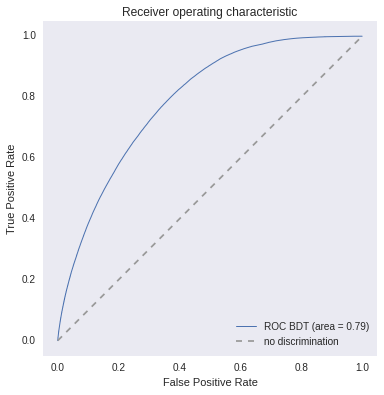

In [10]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

Feature Engenering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [4]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [5]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


In [15]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [19]:
gb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, max_depth=6)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [20]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.80090517263682215

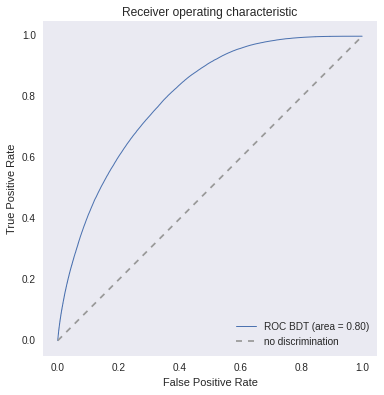

In [21]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's improve it by serching for the best hyperparameters values. 
In the first iteration I want to find the best values of following hyperparameters 
* The cosidered range of n_estimators is between 50 and 250, step = 50
* learning rate in range 0.01-3 with semilogaritmic step

I use only 10% of data for grid search. Should be enough.


In [7]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(49,251) if x % 50 == 0],
                   "learning_rate": [0.01, 0.03,0.1,0.3,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,                               
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);


{'n_estimators': [50, 100, 150, 200, 250], 'learning_rate': [0.01, 0.03, 0.1, 0.3, 1]}
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] .... n_estimators=50, learning_rate=0.01, score=0.738884 -  48.3s


[Parallel(n_jobs=8)]: Done   1 jobs       | elapsed:   49.4s


[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] .... n_estimators=50, learning_rate=0.01, score=0.740385 -  48.7s
[CV] n_estimators=200, learning_rate=0.01 ............................
[CV] .... n_estimators=50, learning_rate=0.01, score=0.741720 -  50.8s
[CV] n_estimators=200, learning_rate=0.01 ............................
[CV] ... n_estimators=100, learning_rate=0.01, score=0.742955 - 1.7min
[CV] n_estimators=200, learning_rate=0.01 ............................
[CV] ... n_estimators=100, learning_rate=0.01, score=0.741665 - 1.8min
[CV] n_estimators=250, learning_rate=0.01 ............................
[CV] ... n_estimators=100, learning_rate=0.01, score=0.745500 - 1.8min
[CV] n_estimators=250, learning_rate=0.01 ............................
[CV] ... n_estimators=150, learning_rate=0.01, score=0.744525 - 2.7min
[CV] n_estimators=250, learning_rate=0.01 ............................
[CV] ... n_estimators=150, learning_rate=0.01, score=0.746119 - 2.7min
[CV] n

[Parallel(n_jobs=8)]: Done  32 jobs       | elapsed: 10.3min


[CV] n_estimators=100, learning_rate=0.1 .............................
[CV] ... n_estimators=200, learning_rate=0.03, score=0.774847 - 4.0min
[CV] ..... n_estimators=50, learning_rate=0.1, score=0.772185 - 1.0min
[CV] n_estimators=100, learning_rate=0.1 .............................
[CV] n_estimators=150, learning_rate=0.1 .............................
[CV] ... n_estimators=200, learning_rate=0.03, score=0.769898 - 4.1min
[CV] n_estimators=150, learning_rate=0.1 .............................
[CV] ... n_estimators=250, learning_rate=0.03, score=0.772692 - 4.7min
[CV] n_estimators=150, learning_rate=0.1 .............................
[CV] .... n_estimators=100, learning_rate=0.1, score=0.780142 - 1.7min
[CV] n_estimators=200, learning_rate=0.1 .............................
[CV] .... n_estimators=100, learning_rate=0.1, score=0.775639 - 1.8min
[CV] n_estimators=200, learning_rate=0.1 .............................
[CV] .... n_estimators=100, learning_rate=0.1, score=0.779923 - 1.8min
[CV] n

[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 24.9min finished


In [8]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 250, 'learning_rate': 0.3}
Grid scores on development set:
0.740 (+/-0.002) for {'n_estimators': 50, 'learning_rate': 0.01}
0.743 (+/-0.003) for {'n_estimators': 100, 'learning_rate': 0.01}
0.746 (+/-0.002) for {'n_estimators': 150, 'learning_rate': 0.01}
0.750 (+/-0.003) for {'n_estimators': 200, 'learning_rate': 0.01}
0.753 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.01}
0.746 (+/-0.002) for {'n_estimators': 50, 'learning_rate': 0.03}
0.757 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.03}
0.767 (+/-0.005) for {'n_estimators': 150, 'learning_rate': 0.03}
0.773 (+/-0.004) for {'n_estimators': 200, 'learning_rate': 0.03}
0.775 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.03}
0.770 (+/-0.004) for {'n_estimators': 50, 'learning_rate': 0.1}
0.779 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.1}
0.782 (+/-0.005) for {'n_estimators': 150, 'learning_rate': 0.1}
0.784 (+/-0.005) for {'n_e

In [9]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=250, max_depth=6)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [10]:
print "ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250


0.81758089824153213

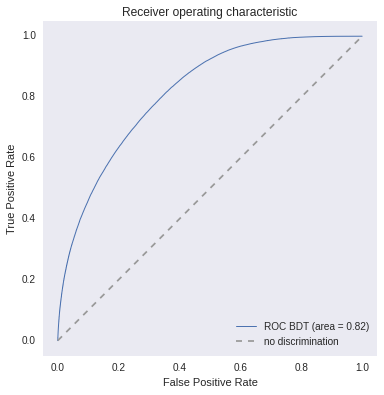

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Show dependency of BDT quality on the number of trees. 
----------
To obtain this values I use staged_predict_proba

In [ ]:
tree_scores = [] 
for tree_nb in range(1,249):
    proba = gb2.predict_proba(new_testX,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores.append(score)

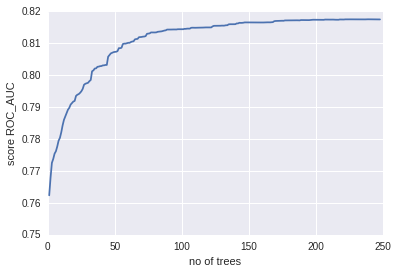

In [17]:
x = numpy.array([x  for x in range(1,249)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Save model to file 
-------
It is a good idea to save BDT parameters to file for further study.  
I use **sklearn.externals.joblib**. According to the documentation is more effitient than pickle. 

In [19]:
joblib.dump(gb2, 'models/XGBoost_200tree.pkl') 

['models/XGBoost_200tree.pkl',
 'models/XGBoost_200tree.pkl_01.npy',
 'models/XGBoost_200tree.pkl_02.npy']

Extend grid search  range of n_estimators to 600. 
-----------------
This time I want to increase classifier score via extending search space.  
I use data without linear feature transformations. 

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(299,601) if x % 50 == 0],
                   "learning_rate": [0.1,0.3,0.7,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);

In [8]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 450, 'learning_rate': 0.3}
Grid scores on development set:
0.787 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.1}
0.788 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.1}
0.789 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.1}
0.790 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.1}
0.791 (+/-0.006) for {'n_estimators': 500, 'learning_rate': 0.1}
0.791 (+/-0.006) for {'n_estimators': 550, 'learning_rate': 0.1}
0.792 (+/-0.007) for {'n_estimators': 600, 'learning_rate': 0.1}
0.793 (+/-0.007) for {'n_estimators': 300, 'learning_rate': 0.3}
0.794 (+/-0.008) for {'n_estimators': 350, 'learning_rate': 0.3}
0.795 (+/-0.007) for {'n_estimators': 400, 'learning_rate': 0.3}
0.795 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.3}
0.795 (+/-0.005) for {'n_estimators': 500, 'learning_rate': 0.3}
0.794 (+/-0.005) for {'n_estimators': 550, 'learning_rate': 0.3}
0.794 (+/-0.006) for {'n_estimato

Train the new model
----------
* n_estimators 400
* learning rate 0.3

In [13]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )

gb3 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, max_depth=6)
gb3.fit(train_X, train_Y)
joblib.dump(gb3, 'models/XGBoost_400trees.pkl') 

['models/XGBoost_400trees.pkl',
 'models/XGBoost_400trees.pkl_01.npy',
 'models/XGBoost_400trees.pkl_02.npy']

In [7]:
gb3 = joblib.load('models/XGBoost_400trees.pkl')
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

In [14]:
print "ROC AUC score"
roc_auc_score(test_Y, gb3.predict_proba(test_X)[:, 1])

ROC AUC score


0.81908188341647703

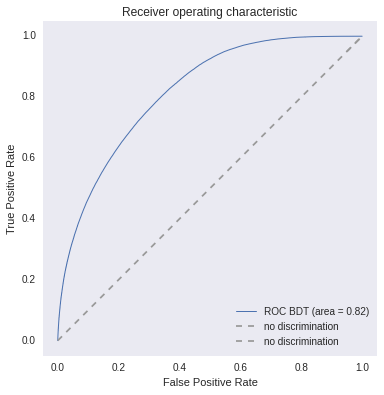

In [15]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

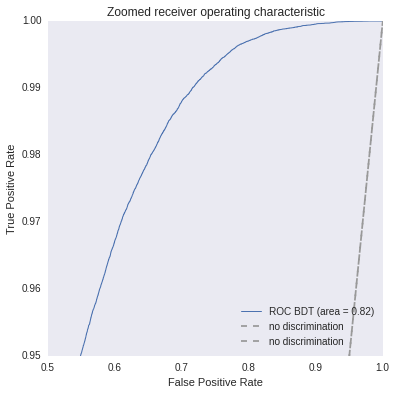

In [31]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb3.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

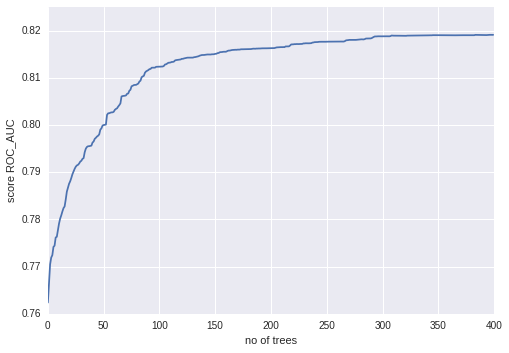

In [26]:
x = numpy.array([x  for x in range(400)])
plt.figure()
plt.plot(x,tree_scores[:400])
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusions
--------
I try to add more features I will use as a number of trees = 300 for further study.  
To get the best, final  result I need to use about 350 trees. 

Model comparison 
---------
In comparable to sklearn's model I obtained about 1% of improvement! This is quite nice. 

Now you can go to the next model - [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========